# 손글씨 숫자 분류기 (MNIST)

이번시간에는 MLP를 이용해서 손글씨 숫자 데이터셋인 MNIST 데이터셋을 분류하는 분류기를 학습해보겠습니다.

## 데이터셋
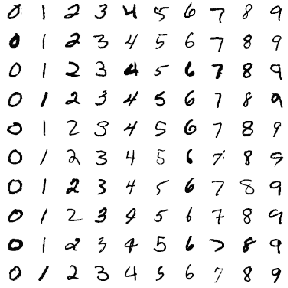


MNIST는 손글씨 숫자 데이터셋으로 0부터 9까지 숫자가 손글씨로 그려진 이미지를 모아놓은 데이터셋입니다. 과거에 우체국에서 편지의 우편번호를 인식하기 위해 만들어진 데이터셋입니다. 

데이터셋의 이미지는 총 70,000개로, 60,000개의 training data와 10,000개의 test data로 나뉘어져있습니다. 

각 이미지는 28x28 픽셀의 흑백이미지 입니다.

따라서 원래 이미지를 Tensor로 불러오면 $(1, 28, 28)$ shape으로 불러와 집니다. MLP는 채널, 가로, 세로 구분이 없기 때문에 이 이미지를 1D Tensor로 만들어서 MLP의 입력으로 넣어줄 것입니다. 1D 로 만들면 $(784,)$ shape으로 바뀔것입니다.

## 학습 기본 설정

pytorch에서 기본적으로 사용되는 설정을 진행합니다.

In [13]:
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

GPU로 학습이 가능한지 체크하고 GPU를 사용하도록 device를 지정합니다.

In [14]:
is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

False cpu


> Colab에서는 `Runtime > change runtime type > Hardware accelerator > GPU`를 선택해서 GPU가 사용가능한 runtime으로 변경을 해주어야 GPU사용이 가능합니다.

다음으로 딥러닝의 재현성(reproducibility)을 위해 랜덤 시드를 고정 시켜줍니다.



In [15]:
random.seed(1010)         # python seed
torch.manual_seed(1010)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(1010)  # gpu seed

다음으로 하이퍼파라미터를 선언합니다.

In [16]:
# Hyperparameters
# Training
EPOCH = 10
BATCH_SIZE = 128
LR = 0.01

# Model
HIDDEN_1 = 32
HIDDEN_2 = 32

## Dataset, DataLoader

이제 데이터를 살펴보았으니 Dataset과 DataLoader를 정의 해보겠습니다.

그전에 pytorch에서 computer vision을 위해 제공해주는 패키지가 있습니다. Torchvision이라는 패키지 인데요, 맨 처음 환경설정할 때 같이 설치를 했는데 기억이 나시나요? 이 Torchvision은 computer vision에서 널리 사용되는 Dataset과 Models, 전처리(Transform) 방법이 포함되어 있습니다.

Torchvision을 이용해서 MNIST 데이터를 불러오겠습니다.

In [17]:
# MNIST dataset
mnist_train = datasets.MNIST(root='MNIST/', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='MNIST/', train=False, download=True, transform=transforms.ToTensor())

첫번째 인자인 root는 MNIST 데이터셋이 저장되어 있는 (저장될) 경로입니다. 다음으로 train은 True라면 학습데이터셋을 False라면 테스트 데이터셋을 의미합니다. download는 root 에 데이터가 없다면 데이터를 다운받게 하는 인자입니다. 마지막 transform은 데이터셋을 로드해서 메모리에 저장하기 전에 Tensor형태로 변경해주라는 뜻입니다. MNIST는 데이터가 작기 때문에 그대로 Tensor형태로 저장하면 되어서 ToTensor만 사용하지만 이미지가 큰 경우 Crop이나 Resize등을 거치는 경우도 흔합니다.

다운받은 데이터셋에서 실제 MNIST 데이터가 어떻게 생겼는지 살펴보겠습니다.

Image Size: torch.Size([28, 28])
Label: 4


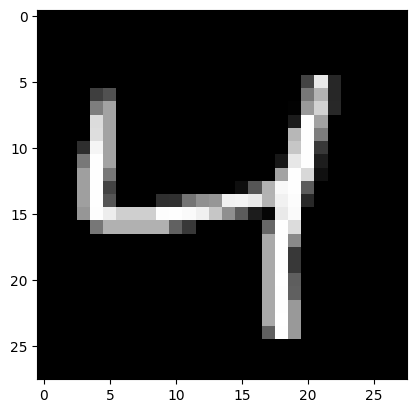

In [18]:
# plt.imshow()
set_label_num = 2
plt.imshow(mnist_train.data[set_label_num], cmap='gray')
print(f"Image Size: {mnist_train.data[set_label_num].shape}")
print(f"Label: {mnist_train.targets[set_label_num]}")

다음으로 데이터로더를 선언합니다.

In [19]:
train_loader = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE)

처음보는 인자인 `drop_last`를 설명하겠습니다.

1000개의 데이터가 있고 batch_size가 128이라면 마지막 배치의 크기는 104개 됩니다. 마지막 배치가 다른 배치보다 샘플 숫자가 적어지면 경사하강법으로 최적화 하는 과정에서 다른 배치보다 과대평가 될 수 있는데 이것을 방지하기 위해 마지막 배치를 사용하지 않도록 하는 것이 `drop_last` 입니다.

## Model

2개의 hidden layer를 갖고있는 MLP 모델을 Pytorch로 생성합니다.
이번에는 `nn.Sequential` 을 이용하여 간단히 모델을 만들어 보겠습니다.

`nn.Sequential`은 pytorch 모듈 중 하나로 모듈들을 입력으로 받습니다. sqeuential의 forward는 직전레이어의 출력은 다음 레이어의 입력으로 넣어주는 형태로 간단하게 구성이 되어 있습니다.

In [20]:
## Model 선언 (RE)
model = nn.Sequential(
  nn.Linear(1*28*28, HIDDEN_1),
  nn.ReLU(),
  nn.Linear(HIDDEN_1, HIDDEN_2),          
  nn.ReLU(),
  nn.Linear(HIDDEN_2, 10),                   
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=10, bias=True)
)


# Loss / Optimizer 정의

10개의 클래스를 구분하는 문제이기 때문에 Multi-class Classification문제 입니다.
이 테스크에 많이 사용되는 `CrossEntropyLoss`를 사용하겠습니다.

Optimizer는 성능이 어느정도 보장되면서 빠르게 학습되는 `Adam` Optimizer를 사용하겠습니다.

In [21]:
# Loss Optimizer 정의 (RE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR) 

## Train / Test

실제 학습과 테스트를 진행하는 함수를 생성합니다.

In [22]:
def train(epoch):
  model.train()

  running_loss = 0
  for i, (data, targets) in enumerate(train_loader):
    data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(data.view(-1, 1*28*28))

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"[{epoch}/{EPOCH}] train loss: {running_loss/len(train_loader):.4f}")
  return running_loss/len(train_loader)

In [23]:
def test():
  model.eval() 
  correct = 0

  with torch.no_grad():
    for data, targets in test_loader:
      data.to(device), targets.to(device)

      outputs = model(data.view(-1, 1*28*28))

      _, predicted = torch.max(outputs, 1)  
      correct += predicted.eq(targets.view_as(predicted)).sum()

  data_num = len(test_loader.dataset)  # 데이터 총 갯수
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

In [24]:
test()

Test Accuracy: 985/10000 (9.85%)


In [25]:
for epoch in range(EPOCH):
  train(epoch)
test()

[0/10] train loss: 0.3271
[1/10] train loss: 0.1716
[2/10] train loss: 0.1407
[3/10] train loss: 0.1299
[4/10] train loss: 0.1205
[5/10] train loss: 0.1128
[6/10] train loss: 0.1048
[7/10] train loss: 0.1033
[8/10] train loss: 0.0973
[9/10] train loss: 0.0978
Test Accuracy: 9622/10000 (96.22%)


# Validation set 

In [16]:
# MNIST dataset
from torch.utils.data.sampler import SubsetRandomSampler

indices = list(range(len(mnist_train)))
split = 50000
train_indices, val_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE)

In [17]:
def validation(epoch):
  model.eval() 

  correct = 0
  running_loss = 0.

  with torch.no_grad():
    for i, (data, targets) in enumerate(val_loader):
      data.to(device), targets.to(device)
      
      outputs = model(data.view(-1, 1*28*28))
      loss = criterion(outputs, targets)
      running_loss += loss.item()

      _, predicted = torch.max(outputs, 1)  
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # 정확도 출력
  data_num = len(val_indices)  # 데이터 총 건수
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] val loss: {running_loss/len(val_loader):.4f} val acc: {correct}/{data_num} ({acc:.0f}%)')
  
  return running_loss/len(val_loader)

In [20]:
train_losses = []
val_losses = []
for epoch in range(EPOCH):
  tloss = train(epoch)
  vloss = validation(epoch)
  train_losses.append(tloss)
  val_losses.append(vloss)
test()

[0/10] train loss: 0.3380
[0/10] val loss: 0.1721 val acc: 9495/10000 (95%)
[1/10] train loss: 0.1737
[1/10] val loss: 0.1428 val acc: 9560/10000 (96%)
[2/10] train loss: 0.1435
[2/10] val loss: 0.1409 val acc: 9581/10000 (96%)
[3/10] train loss: 0.1230
[3/10] val loss: 0.1395 val acc: 9602/10000 (96%)
[4/10] train loss: 0.1093
[4/10] val loss: 0.1371 val acc: 9610/10000 (96%)
[5/10] train loss: 0.1074
[5/10] val loss: 0.1415 val acc: 9624/10000 (96%)
[6/10] train loss: 0.0993
[6/10] val loss: 0.1476 val acc: 9613/10000 (96%)
[7/10] train loss: 0.1018
[7/10] val loss: 0.1433 val acc: 9643/10000 (96%)
[8/10] train loss: 0.0903
[8/10] val loss: 0.1474 val acc: 9615/10000 (96%)
[9/10] train loss: 0.0857
[9/10] val loss: 0.1565 val acc: 9610/10000 (96%)
Test Accuracy: 9596/10000 (95.96%)


## 시각화
위에서 수집한 각 epoch별 loss를 시각화 하여 학습이 어떻게 진행되었는지 알아보겠습니다.

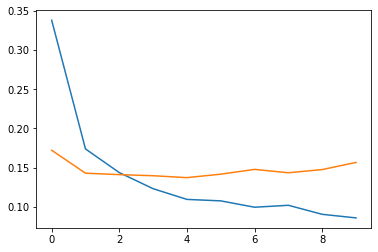

In [21]:
plt.plot(train_losses)
plt.plot(val_losses)

epoch 이 지남에 따라 Train과 Validation Loss 점점 줄어들다가 2 Epoch 부근에서 train loss는 계속 줄어들지만, Validation loss 는 줄어들지 않고 오히려 늘어나는 양상을 보입니다.

바로 이 부분이 앞에서 살펴보았던 Overfitting이 발생한 부분입니다.
Training set에 너무 집중한 나머지 일반화 성능이 떨어지게 되죠.

테스트 샘플중 한 이미지를 예측해보고 결과를 시각화 해보겠습니다.

Prediction: 1 / Label: 1


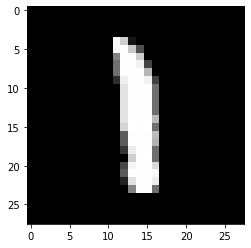

In [23]:
model.eval()

idx = 777
data = mnist_test.data[idx]
label = mnist_test.targets[idx]

output = model(data.view(28*28).float())
pred = torch.argmax(output)

print(f"Prediction: {pred} / Label: {label}")
plt.imshow(data, cmap='gray')